# Generating heatmap for the chemotaxonomy

### Import modules

In [1]:
import os
from ast import literal_eval

import pandas as pd
from tqdm import tqdm

# Import taxonomy
from utils import get_genus_and_family_info_for_plants

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 360
%matplotlib inline

In [3]:
tqdm.pandas()
pd.set_option('display.max_columns', None)

In [4]:
DATA_DIR = '../data/'

Load chemicals

In [5]:
plant_chemical_df = pd.read_csv(
    os.path.join(DATA_DIR, 'plant_chemical_associations.tsv.gz'),
    compression='gzip',
    sep='\t',
    usecols=[
        'plant_curie',
        'chemical_curie',
    ]
)

In [6]:
plant_chemical_df.head(1)

,plant_curie,chemical_curie
0,ncbitaxon:1000425,pubchem.compound:3527


In [7]:
len(plant_chemical_df.chemical_curie.unique())

87019

### Extract chemical classes

Load NPClassifier classes

In [8]:
np_classifier_dict = pd.read_csv(
    os.path.join(DATA_DIR, 'npclassifier_smiles.tsv.gz'),
    sep='\t',
    compression='gzip',
    usecols=[
        'pubchem_openeye_can_smiles',
        'class_results'
    ],
    index_col='pubchem_openeye_can_smiles'
).to_dict()['class_results']
len(np_classifier_dict)

638605

# Convert the SMILEs to PubChem ids

In [9]:
smiles_df = pd.read_csv(
    os.path.join(DATA_DIR, 'smiles.tsv.gz'),
    sep='\t',
    compression='gzip',
)

In [10]:
pubchem_to_smiles = {}
all_smiles = set()

chemicals_in_plants = set(plant_chemical_df.chemical_curie.unique())

for pubchem_id, smiles in tqdm(smiles_df.values):
        
    if pubchem_id.startswith('pubchem:'):
        pubchem_id = pubchem_id.replace('pubchem:', 'pubchem.compound:')
        
    if pubchem_id not in chemicals_in_plants:
        continue
    
    all_smiles.add(smiles)
    pubchem_to_smiles[pubchem_id] = smiles

smiles_to_pubchem = {
    smiles: pubchem
    for pubchem, smiles in pubchem_to_smiles.items()
}

100%|██████████| 89271/89271 [00:00<00:00, 397581.27it/s]


In [11]:
# Multiple classes associated with each chemical
np_classifier_dict = {
    smiles_to_pubchem[smile]: literal_eval(classes)
    for smile, classes in np_classifier_dict.items()
    if smile in smiles_to_pubchem and len(literal_eval(classes)) > 0
}
len(np_classifier_dict)

52430

### Compound class annotation

In [12]:
np_classifier_annotated_plants = plant_chemical_df.copy(deep=True)
np_classifier_annotated_plants['class'] = np_classifier_annotated_plants['chemical_curie'].map(np_classifier_dict)
np_classifier_annotated_plants = np_classifier_annotated_plants.explode('class')

In [13]:
# all plants
np_classifier_annotated_plants.shape

(415969, 3)

In [14]:
np_classifier_annotated_plants.dropna(subset=['class'], inplace=True)
np_classifier_annotated_plants.shape

(308674, 3)

### Create plant-class vectors
e.g., plant A: [class1, class2, class3, ...]

In [15]:
def create_np_classifier_vectors(df: pd.DataFrame):
    all_classes = set(df['class'].unique())
    plants = set(df['plant_curie'].unique())
    
    vector_data = []
    
    for plant_name in tqdm(plants, desc='Generated NP-Classifier vectors'):
        phytochem_df = df[df['plant_curie'] == plant_name]
        
        t = {
            'plant_name': plant_name,
        }
        
        for class_name in all_classes:
            temp = phytochem_df[phytochem_df['class'] == class_name]
            t[class_name] = len(temp['chemical_curie'].unique())
        
        vector_data.append(t)
            
    return pd.DataFrame(vector_data)

In [16]:
plant_to_npclassifier_vectors = create_np_classifier_vectors(np_classifier_annotated_plants)

Generated NP-Classifier vectors: 100%|██████████| 17907/17907 [1:19:02<00:00,  3.78it/s]


In [17]:
plant_to_npclassifier_vectors.head(2)

,plant_name,Phenanthrenes,Simple amide alkaloids,Silphinane sesquiterpenoids,Sacculatane diterpenoids,Miscellaneous apocarotenoids,RiPPs-Amatoxins and Phallotoxins,Ishwarane sesquiterpenoids,Tigliane diterpenoids,3-Spirotetramic acids,Pyrroloindole alkaloids,Phenylethanoids,Cyclonerane sesquiterpenoids,Sterpurane sesquiterpenoids,Rhamnolipids,Irregular monoterpenoids,Angucyclines,Naphthalenes and derivatives,Bufadienolides,Cycloapotirucallane triterpenoids,Glycerophosphoinositols,Fungal cyclic polyketides (Miscellaneous),Monacolins and Monacolin derivatives,Sphenolobane diterpenoids,Quadrane sesquiterpenoids,Methoxy fatty acids,Allohimachalane sesquiterpenoids,Aporphine alkaloids,N-acyl ethanolamines (endocannabinoids),Selaginellins,Cucurbitane triterpenoids,Cembrane diterpenoids,Glycerophosphoinositol phosphates,Protoberberine alkaloids,"Carotenoids (C40, ε-ε)",Protoilludane sesquiterpenoids,Secoabietane diterpenoids,Spongiane diterpenoids,Norkaurane diterpenoids,Humbertiane sesquiterpenoids,Acetate-derived alkaloids,Cyclobisabolane sesquiterpenoids,Cephalosporins,Steroidal alkaloids,Secolabdane diterpenoids,"Apocarotenoids (C30, Ψ-Ψ)",Other indole diketopiperazine alkaloids,Tripeptides,Iboga type,Hydroxy-hydroperoxyeicosatetraenoic acids,Cadinane sesquiterpenoids,Coumestan,Monosaccharides,Gymnomitrane sesquiterpenoids,Diacylglycerols,Tetrahydroisoquinoline alkaloids,Primary amides,Coumaronochromones,2-pyrone derivatives,Panasinsane sesquiterpenoids,Polyether ionophores,Capsaicins and Capsaicinoids,m-Terphenyls,Dimeric phloroglucinols,Tetrodotoxins,Pulvinones,"Carotenoids (C40, κ-κ)",Drimane sesquiterpenoids,Strychnos type,Fatty aldehydes,Furofuranoid lignans,Benastatins and derivatives,Oxo fatty acids,"Indole diketopiperazine alkaloids (L-Trp, L-Trp)",Aphidicolane diterpenoids,Mulinane diterpenoids,Griseofulvins,Halimane diterpenoids,Miscellaneous meroterpenoids,Simple aromatic polyketides,Thiodiketopiperazine alkaloids,Carbapenems,Copacamphane sesquiterpenoids,Dihydroflavonols,Trichothecane sesquiterpenoids,Dipeptides,Iphionane sesquiterpenoids,Chamigrane sesquiterpenoids,Nonadrides,Morphinan alkaloids,Polyprenylated cyclic polyketides (Hop meroterpenoids),Fungal DPEs,Valerane sesquiterpenoids,"Carotenoids (C40, β-κ)",Verrucosane diterpenoids,Scalarane sesterterpenoids,Indole-Diterpenoid alkaloids (Penitrems),Ansa macrolides,Vitamin D2 and derivatives,Valerenane sesquiterpenoids,Open-chained neoflavonoids,Acyl phloroglucinols,Methyl xanthones,Clovane sesquiterpenoids,"Lanostane, Tirucallane and Euphane triterpenoids","Indole diketopiperazine alkaloids (L-Trp, L-Ala)",Isolactarane sesquiterpenoids,Taraxerane triterpenoids,Glycerophosphoserines,Pyrrole alkaloids,Anthocyanidins,Longipinane sesquiterpenoids,Pinane monoterpenoids,Elemane sesquiterpenoids,Stictane triterpenoids,Glycosylmonoacylglycerols,Cheilanthane sesterterpenoids,Neoflavonoids,Imidazole alkaloids,Coumarinolignans,Megastigmanes,Bicyclogermacrane sesquiterpenoids,Fatty acyl CoAs,Cholane steroids,Shikimic acids and derivatives,Caryophyllane sesquiterpenoids,Fusicoccane diterpenoids,Rotenoids,Dolichols,Cryptophycins,Glycerophosphates,Carbazole alkaloids,Spirovetivane sesquiterpenoids,Erythroxylane diterpenoids,Laurane sesquiterpenoids,Apocarotenoids (β-),Eudesmane sesquiterpenoids,Devadarane diterpenoids,Labdane diterpenoids,Noreremophilane sesquiterpenoids,Fusidane triterpenoids,Dibenzylbutane lignans,Prostaglandins,Isocoumarins,Linear peptides,Phytofurans,Filicane triterpenoids,Nardosinane sesquiterpenoids,Phenylethylamines,Disaccharides,Jasmonic acids,Abeolupane triterpenoids,Asteriscane sesquiterpenoids,Lippifoliane sesquiterpenoids,p-Terphenyls,Thujane monoterpenoids,Aromadendrane sesquiterpenoids,Plant xanthones,Aflatoxins,Secoiridoid monoterpenoids,Norpimarane and Norisopimarane diterpenoids,N-acyl amines,Ansa peptide alkaloids,Gibberellins,Acorane sesquiterpenoids,Cuparane sesquiterpenoids,Melithiazole and Myxothiazole derivatives,Ericamycins,Dialkylresorc

### Collapsing plant species to plant families

In [18]:
genus_to_species, family_to_species = get_genus_and_family_info_for_plants(
    set(plant_chemical_df.plant_curie.unique())
)

order genus: 100%|██████████| 16884/16884 [00:00<00:00, 25461.38it/s]


# Plot the number of chemicals per family/genus

In [19]:
def plot_chemical_distribution(taxon_to_species):
    """Plot chemical distribution."""
    
    rows = []
    
    for taxon_name, species in tqdm(taxon_to_species.items()):
        unique_chemicals = plant_chemical_df[
            plant_chemical_df['plant_curie'].isin(species)
        ].chemical_curie.unique()
        
        rows.append({
            'taxon_group': taxon_name,
            'chemical_count': len(unique_chemicals),
        })
        
    df = pd.DataFrame(rows)
    df.set_index('taxon_group', inplace=True)
    
    g = sns.displot(
        data=df,
        x='chemical_count',
        stat="density",
        kde=True,
        common_norm=False,
        height=4,
        aspect=1.5,
        bins=1000,
        alpha=0.7,
    )

#     g.set(xlim=(-1, 10000))

    plt.show()

100%|██████████| 4843/4843 [01:02<00:00, 77.62it/s]


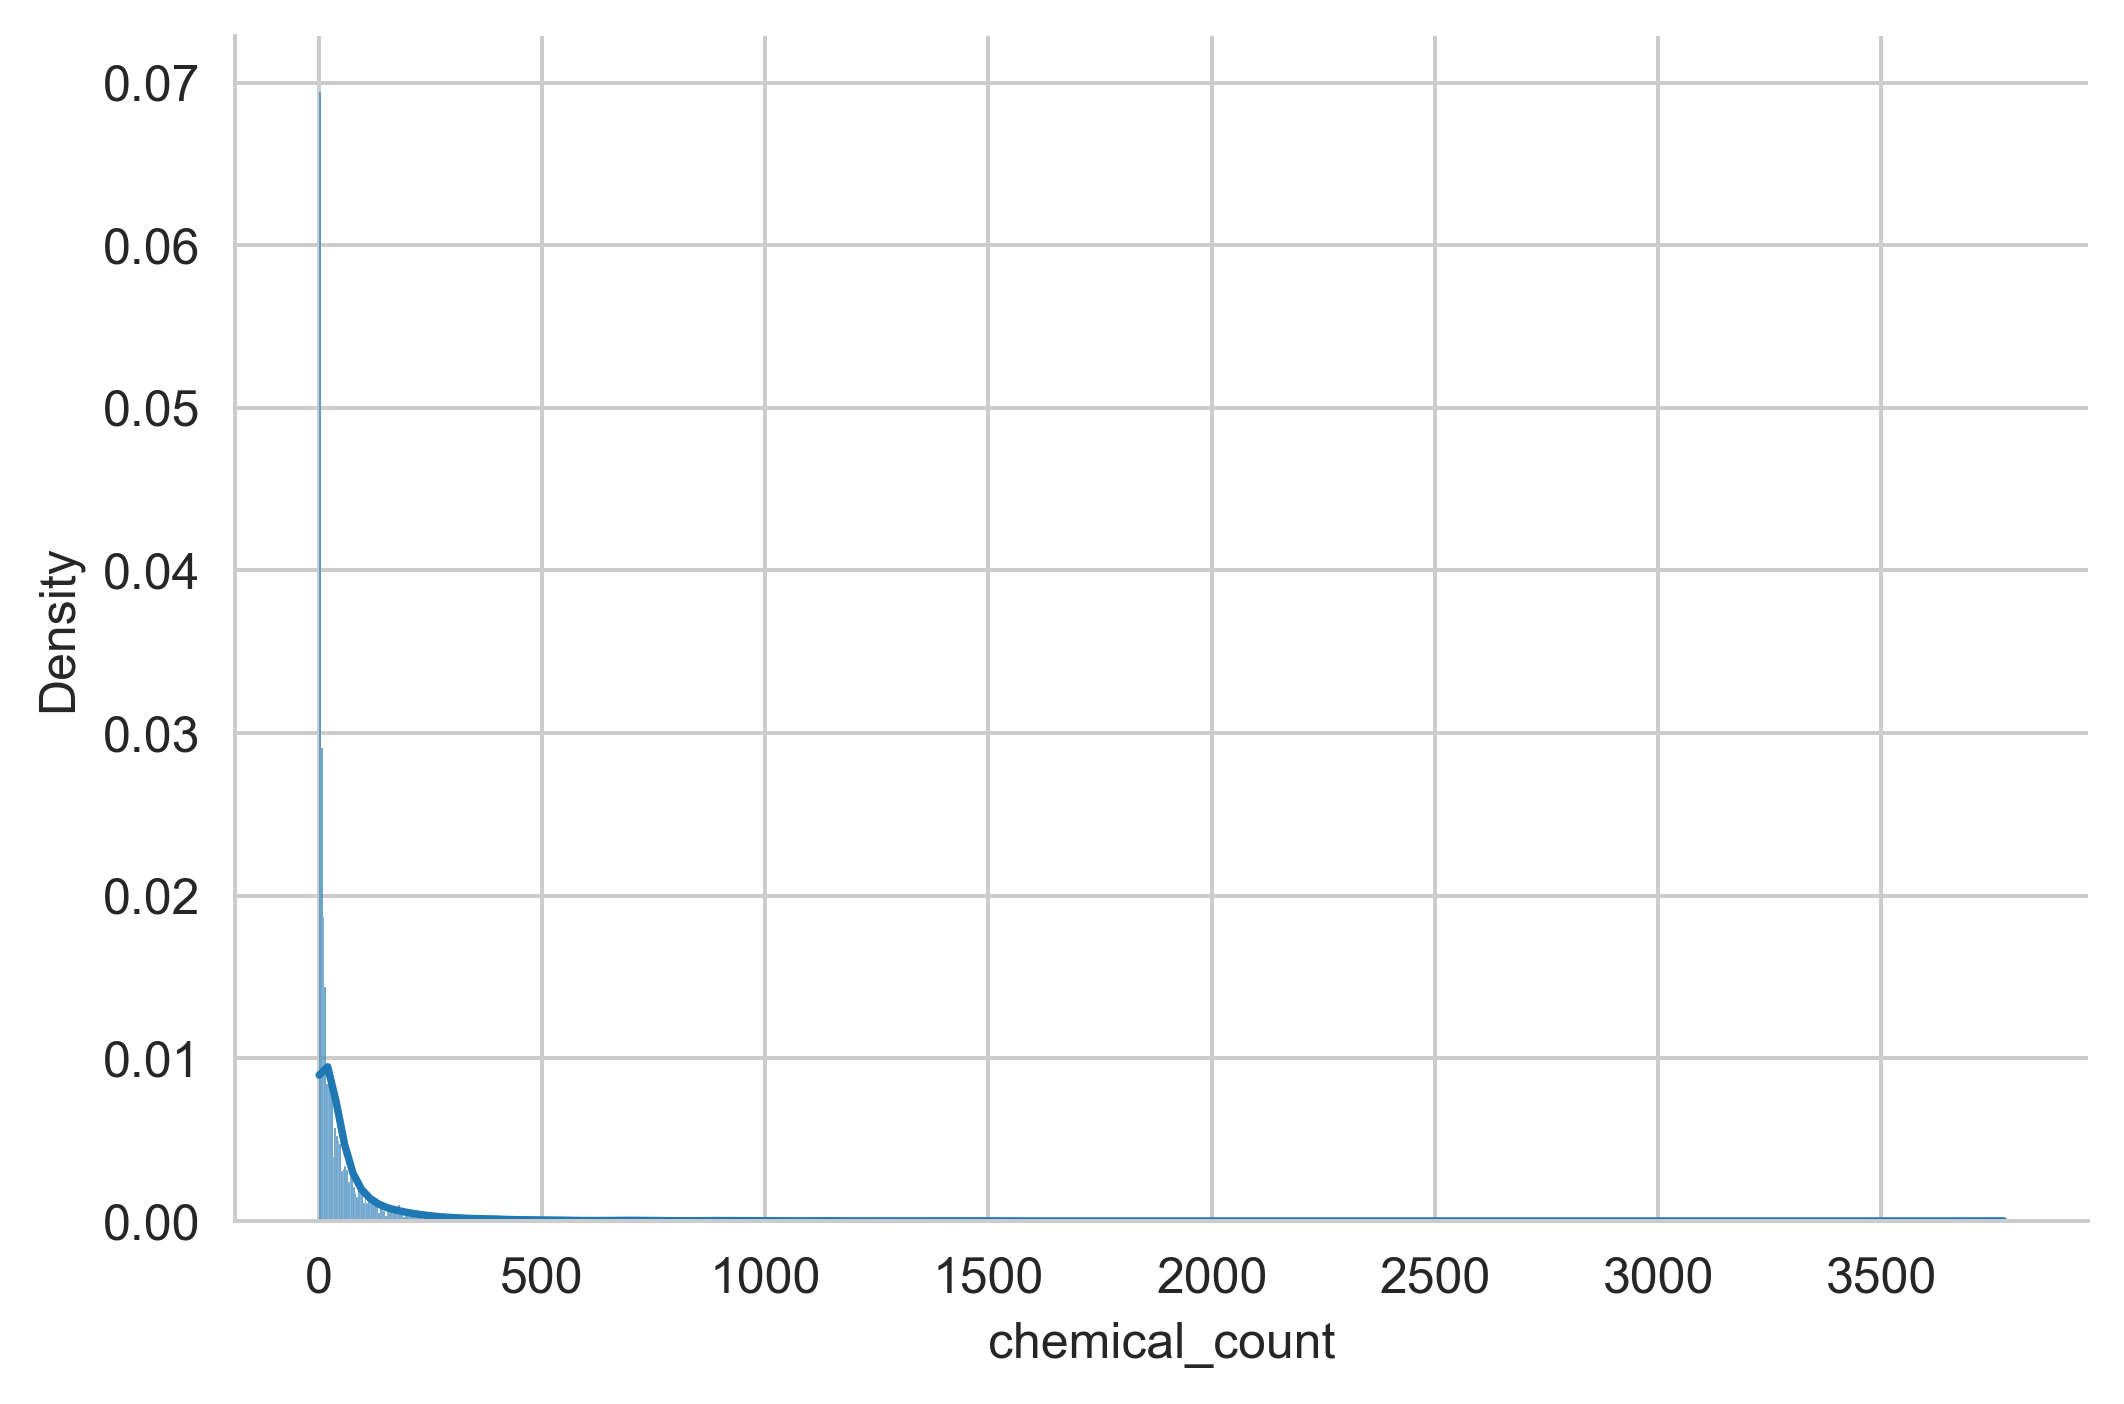

In [20]:
# Genus level
plot_chemical_distribution(genus_to_species)

100%|██████████| 513/513 [00:08<00:00, 59.06it/s]


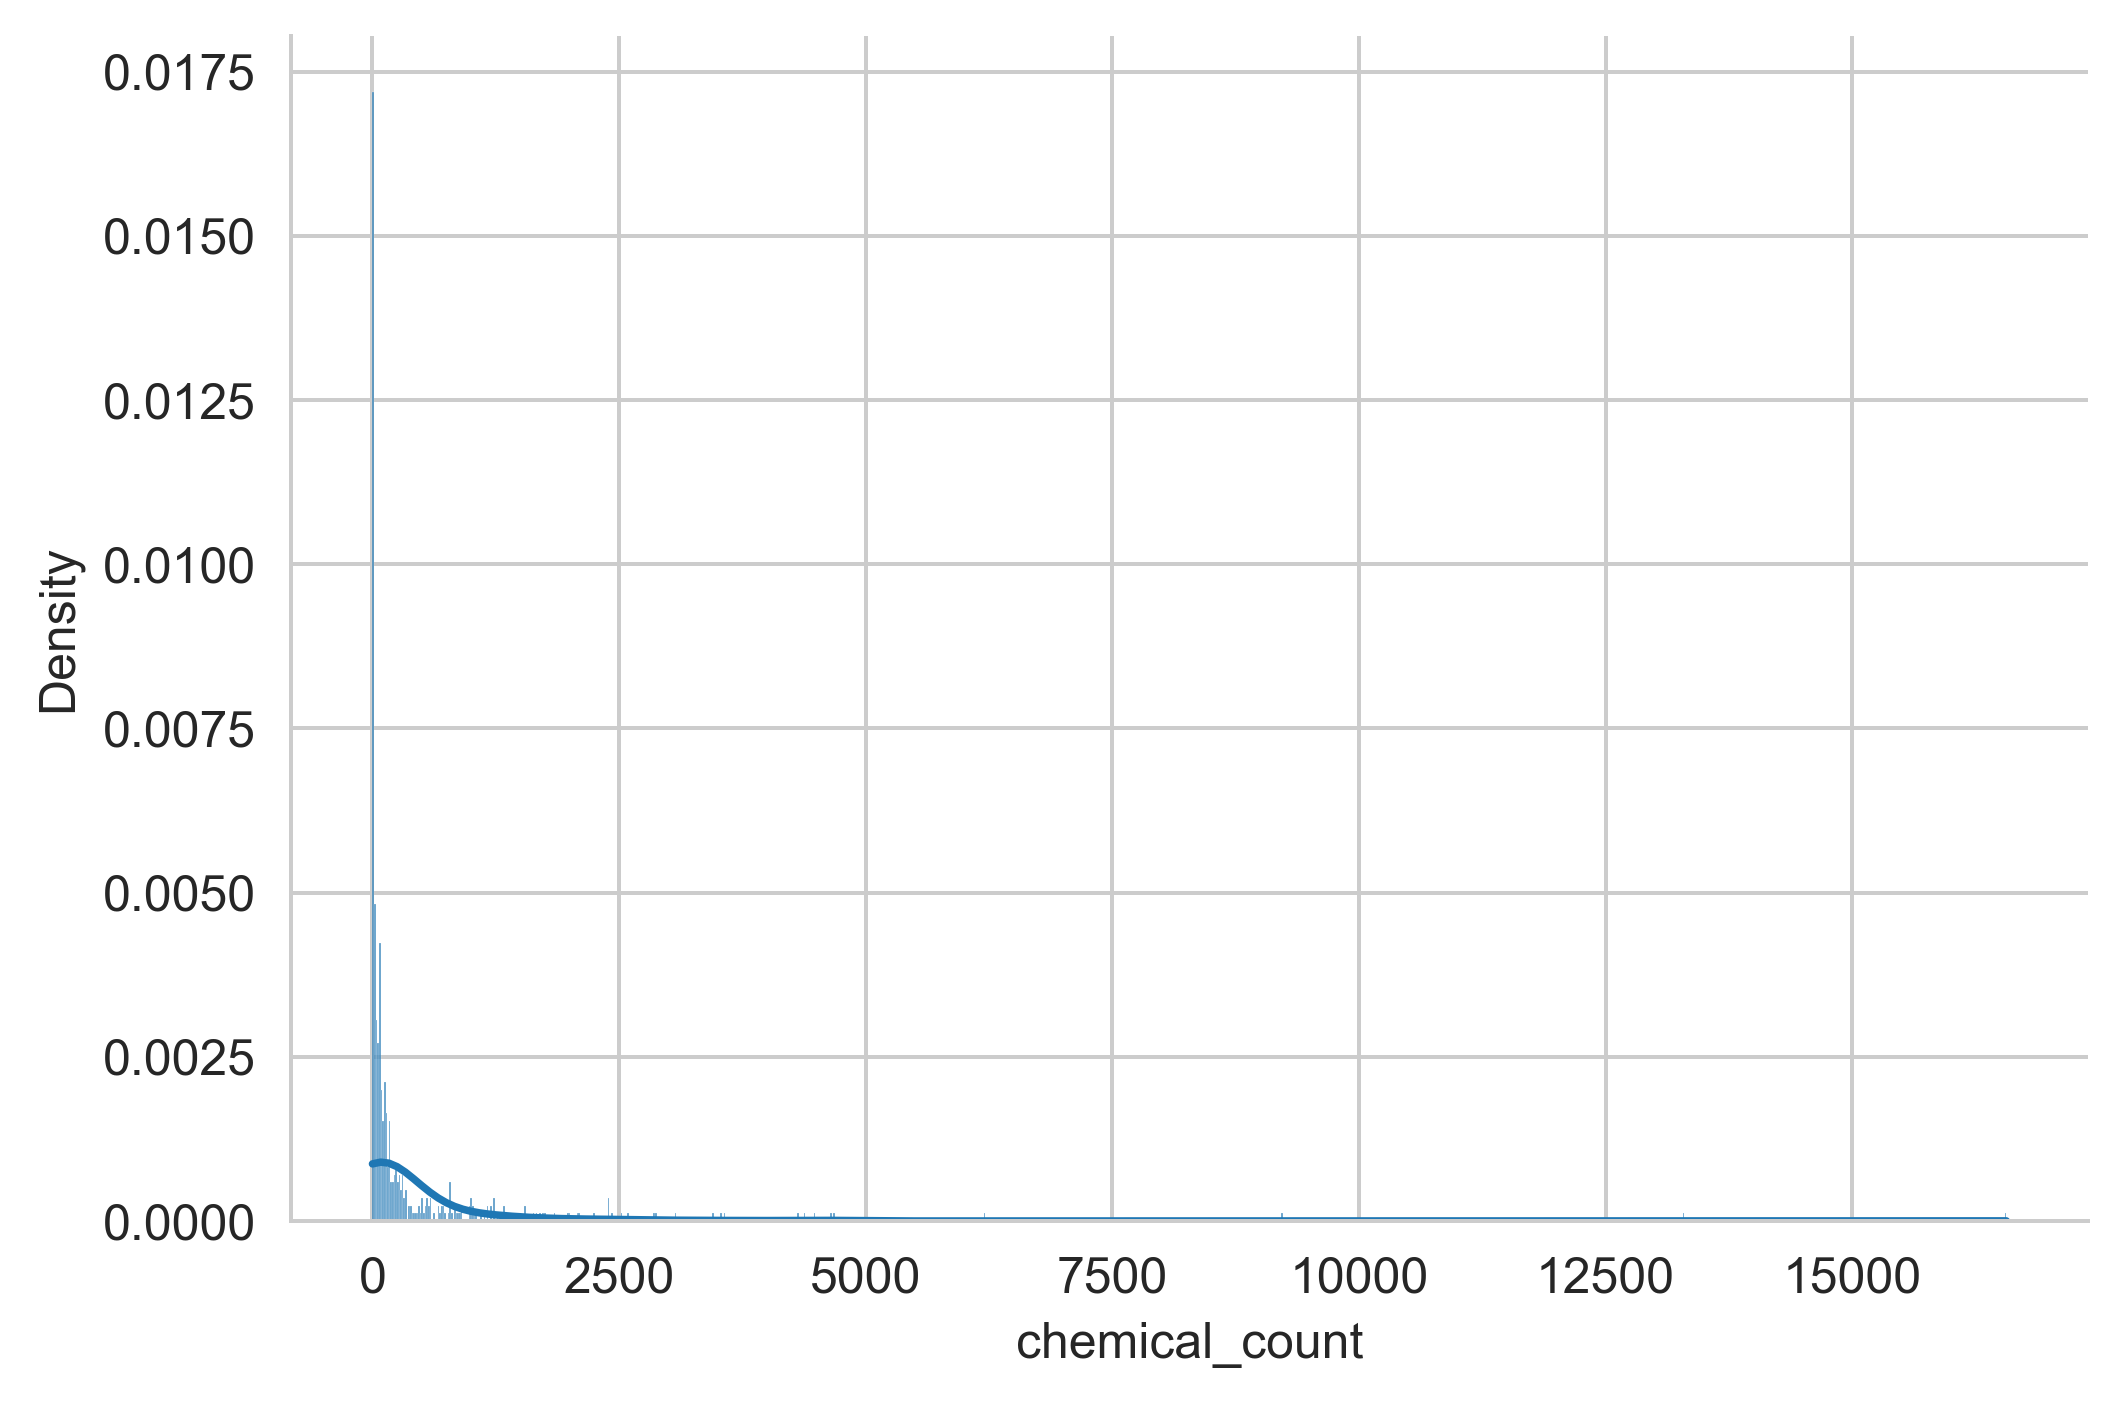

In [21]:
# Family level
plot_chemical_distribution(family_to_species)

In [22]:
def collapse_to_family(df: pd.DataFrame, taxon_group):
    
    data = []
    skipped_empty = 0
    skipped_low = 0
    
    for family_curie, species in tqdm(taxon_group.items()):
        tmp_df = df[df['plant_name'].isin(species)]
        
        if tmp_df.empty:
            skipped_empty +=1
            continue
            
        tmp_df = tmp_df.drop(columns=['plant_name'])
        
        # Remove family/genus with chemical class less than 10
        if tmp_df.sum().sum() < 10:
            skipped_low +=1
            continue
        
        row_dict = tmp_df.sum().to_dict()
        row_dict['taxon'] = family_curie
        
        data.append(row_dict)

    print('Empty skipped empty:', skipped_empty)
    print('Empty skipped less than 10 chemicals:', skipped_low)
    
    df = pd.DataFrame(data)
    df.set_index('taxon', inplace=True)
    df.fillna(0, inplace=True)

    return df

In [23]:
np_classifier_family_df = collapse_to_family(plant_to_npclassifier_vectors, family_to_species)
np_classifier_genus_df = collapse_to_family(plant_to_npclassifier_vectors, genus_to_species)

100%|██████████| 513/513 [00:02<00:00, 187.12it/s]


Empty skipped empty: 24
Empty skipped less than 10 chemicals: 108


100%|██████████| 4843/4843 [00:16<00:00, 294.68it/s]


Empty skipped empty: 348
Empty skipped less than 10 chemicals: 1803


In [24]:
np_classifier_family_df.to_csv(
    os.path.join(DATA_DIR, 'np_classifier_family_vector.tsv'),
    sep='\t'
)
np_classifier_genus_df.to_csv(
    os.path.join(DATA_DIR, 'np_classifier_genus_vector.tsv'),
    sep='\t'
)